In [1]:
from scipy.sparse import csr_matrix
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
import itertools
import matplotlib.pyplot as plt
import numpy as np
import time
import re
%matplotlib inline

## Татьяна Колмакова
## Задание по практикуму №2 в осеннем семестре 2016-2017 учебного года.
### Используемая версия языка Python - 3.5

Для удобства просмотра разобьем задание на две части. 
* Первая часть посвящена работе с датасетом **MNIST** (база рукописных цифр). 
* Вторая часть - работе с датасетом **20 newsgroups**, содержащим в себе 20 различных подборок с новостных сайтов.



## Вторая часть

Загружаем обучающую и тестовую выборку датасета 20 newsgroups. Удаляем все заголовки и цитаты:

In [2]:
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

Выделяем данные для обучения:

In [3]:
train_data = np.array(newsgroups_train.data)
train_target = np.array(newsgroups_train.target)
test_data = np.array(newsgroups_test.data)
test_target = np.array(newsgroups_test.target)

Переводим во всех документах все буквы в нижний регистр. 
Заменяем во всех документах символы, не являющиеся буквами и цифрами, на пробелы.

In [4]:
def to_lower(data):
    lower_data = []
    for term in data:
        spaced_term = re.sub('[^0-9a-zA-Z]+', ' ', term)
        lower_data.append(str.lower(spaced_term))
    return lower_data

In [5]:
lower = to_lower(train_data)

Разделяем на термы по пробельным символам:

In [48]:
def get_terms(data):
    terms = []
    for term in data:
        if type(term) == str:
            terms.append(term.split())
        elif type(term) == list:
            terms.append(term)
    return terms

In [7]:
terms = get_terms(lower)

Преобразовываем датасет в разреженную матрицу:

In [8]:
def to_sparse(terms, dic):
    indptr = [0]
    indices = []
    data = []
    dic_size = len(dic.keys())
    if (dic_size == 0):
        TRAIN_MODE = True
        dic_size = 1
    else:
        TRAIN_MODE = False
    for term in terms:
        cur_dic = dict()
        for word in term:
            if not (word in dic):
                if TRAIN_MODE:
                    dic[word] = dic_size
                    dic_size = dic_size + 1
                else:
                    continue
            if not (dic[word] in cur_dic):
                cur_dic[dic[word]] = 1
            else:
                cur_dic[dic[word]] = cur_dic[dic[word]] + 1
        indices.extend(list(cur_dic.keys()))
        data.extend(list(cur_dic.values()))
        indptr.append(len(data))   
    return csr_matrix((np.array(data), np.array(indices), np.array(indptr)), shape=(len(terms), len(dic)))

In [9]:
dic = dict()
sparse = to_sparse(terms, dic)

Произведем tf-idf преобразование датасета припомощи sklearn.feature_extraction.text.TfidfTransformer, используем параметры по умолчанию.

In [11]:
extract = TfidfTransformer()
tf_idf = extract.fit_transform(sparse)

tf-idf преобразование оценивает важность слова в контексте документа. В этом преобразовании вес слова пропорционален количеству у потребления этого слова.

Оцениваем точность (долю правильно предсказанных ответов) и скорость метода k ближайших соседей при помощи кросс-валидации с 3 фолдами в зависимости от следующих параметров:
 - k принимает значение от 1 до 10 (для оценки точности).
 - Метрика принимает значения 'euclidean' и 'cosine'.
 - Используется ли преобразование tf-idf.
 - Взвешенный алгоритм или нет.

Для наглядности построим графики.

In [10]:
import cross_validation as cv

In [12]:
num_folds = 3
sparse_folds = cv.kfold(sparse.shape[0], num_folds)
tf_idf_folds = cv.kfold(tf_idf.shape[0], num_folds)

In [44]:
def accuracy_plot(matrix, weights, folds):
    k_list = list(range(1, 11))
    metrics = ['euclidean', 'cosine']
    for fig, metric in enumerate(metrics):
        plt.figure(fig)
        acc = cv.knn_cross_val_score(X=matrix, 
                                     y=train_target, 
                                     k_list=k_list, 
                                     score='accuracy', 
                                     cv=folds, 
                                     weights=weights, 
                                     metric=metric, 
                                     strategy='brute', 
                                     test_block_size=None)
        print (np.max(list(acc.values())))
        plt.plot(k_list, [np.mean(value) for value in acc.values()], linewidth=2.0)
        plt.title('Accuracy depends on k %s' % metric)
        plt.xlabel('k')
        plt.ylabel('accuracy')
        plt.show()

0.206576504906


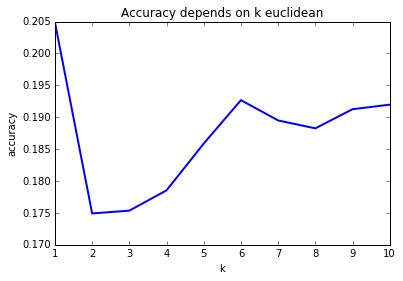

0.294616812517


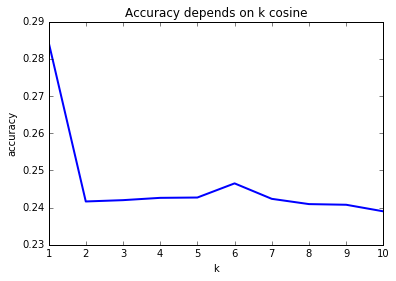

In [45]:
accuracy_plot(sparse, False, sparse_folds)

0.220042417815


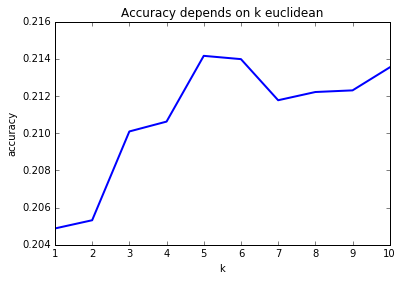

0.294616812517


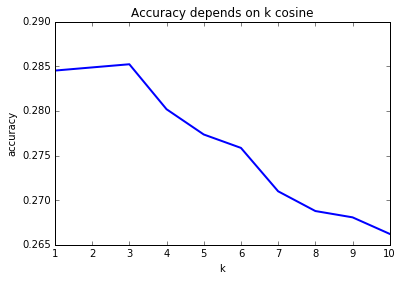

In [46]:
accuracy_plot(sparse, True, sparse_folds)

0.15804826306


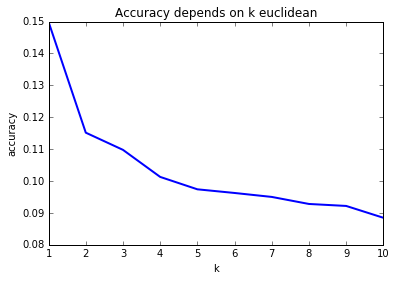

0.595597984619


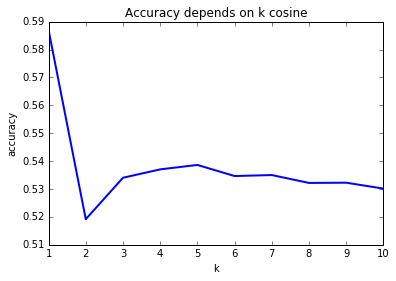

In [47]:
accuracy_plot(tf_idf, False, tf_idf_folds)

0.15804826306


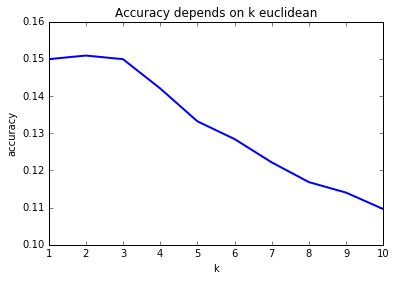

0.598249801114


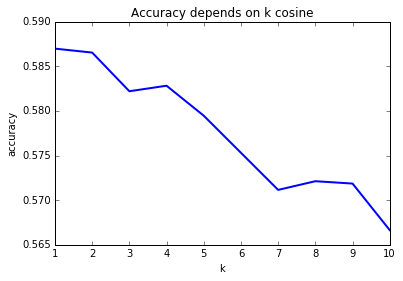

In [48]:
accuracy_plot(tf_idf, True, tf_idf_folds)

Лучшим алгоритмом оказался взвешенный алгоритм с косинусной метрикой, использующей преобразование tf-idf. Косинусная метрика больше подходит для текстов. Преобразование tf-idf специальный метод для работы с текстами. Поэтому результат не удивителен.

In [19]:
def time_it(matrix, metric, weights, k_list, folds):
    start = time.clock()
    %time cv.knn_cross_val_score(X=matrix, y=train_target, k_list=k_list, score='accuracy', cv=folds, weights=weights, metric=metric, strategy='brute', test_block_size=None)
    return time.clock()-start

Время работы с разреженной матрицей:

In [22]:
euclidean_not_weighted_sparse = time_it(sparse, 'euclidean', False, [1], sparse_folds)

CPU times: user 6.29 s, sys: 1.3 s, total: 7.59 s
Wall time: 7.66 s


In [23]:
euclidean_weighted_sparse = time_it(sparse, 'euclidean', True, [8], sparse_folds)

CPU times: user 7.29 s, sys: 1.22 s, total: 8.52 s
Wall time: 8.6 s


In [24]:
cosine_not_weighted_sparse = time_it(sparse, 'cosine', False, [1], sparse_folds)

CPU times: user 6.13 s, sys: 1.32 s, total: 7.45 s
Wall time: 7.55 s


In [25]:
cosine_weighted_sparse = time_it(sparse, 'cosine', True, [1], sparse_folds)

CPU times: user 6.36 s, sys: 1.45 s, total: 7.81 s
Wall time: 8.18 s


Время работы с tf-idf:

In [26]:
euclidean_not_weighted_tf_idf = time_it(tf_idf, 'euclidean', False, [1], tf_idf_folds)

CPU times: user 6.01 s, sys: 1.48 s, total: 7.49 s
Wall time: 7.86 s


In [27]:
euclidean_weighted_tf_idf = time_it(tf_idf, 'euclidean', True, [1], tf_idf_folds)

CPU times: user 5.61 s, sys: 1.21 s, total: 6.81 s
Wall time: 6.94 s


In [28]:
cosine_not_weighted_tf_idf = time_it(tf_idf, 'cosine', False, [1], tf_idf_folds)

CPU times: user 5.5 s, sys: 1.23 s, total: 6.73 s
Wall time: 6.88 s


In [29]:
cosine_weighted_tf_idf = time_it(tf_idf, 'cosine', True, [1], tf_idf_folds)

CPU times: user 5.44 s, sys: 1.15 s, total: 6.59 s
Wall time: 6.68 s


Для более наглядного представления разместим данные в таблице:

In [30]:
table = dict()
table['Matrix type'] = ['sparse', 'sparse', 'sparse', 'sparse', 'tf-idf', 'tf-idf', 'tf-idf', 'tf-idf']
table['Metric'] = ['euclidean', 'euclidean', 'cosine', 'cosine', 'euclidean', 'euclidean', 'cosine', 'cosine']
table['Weights'] = [False, True, False, True, False, True, False, True]
table['Time'] = [euclidean_not_weighted_sparse, euclidean_weighted_sparse, cosine_not_weighted_sparse, cosine_weighted_sparse, euclidean_not_weighted_tf_idf, euclidean_weighted_tf_idf, cosine_not_weighted_tf_idf, cosine_weighted_tf_idf]

In [33]:
df = pd.DataFrame(data=table)

In [40]:
grouped = df.groupby(['Matrix type'])
grouped.get_group('sparse')

,Matrix type,Metric,Time,Weights
0,sparse,euclidean,7.592215,False
1,sparse,euclidean,8.518714,True
2,sparse,cosine,7.452623,False
3,sparse,cosine,7.816759,True


In [43]:
grouped.get_group('tf-idf')

,Matrix type,Metric,Time,Weights
4,tf-idf,euclidean,7.489700,False
5,tf-idf,euclidean,6.816340,True
6,tf-idf,cosine,6.731192,False
7,tf-idf,cosine,6.594582,True


Как можно наблюдать из этих таблиц, алгоритм, использующий tf-idf, более быстрый.

Наилучшим алгоритмом, с точки зрения точности оценивания, оказался взвешанный алгоритм с косинусной метрикой. Применим его ко всей выборке.

Преобразуем тестовую выборку:

In [49]:
import nearest_neighbors as knn

In [14]:
test_terms = get_terms(to_lower(test_data))
test_tf_idf = extract.fit_transform(to_sparse(test_terms, dic))

In [15]:
clf = knn.KNN_classifier(k=1, strategy='brute', metric='cosine', weights=True, test_block_size=None)
clf.fit(tf_idf, train_target)
y_pred_1 = clf.predict(test_tf_idf)

In [16]:
print('Accuracy score =', cv.accuracy_score(y_pred_1, test_target))

Accuracy score = 0.5010621348911312


In [17]:
clf = knn.KNN_classifier(k=2, strategy='brute', metric='cosine', weights=True, test_block_size=None)
clf.fit(tf_idf, train_target)
y_pred_2 = clf.predict(test_tf_idf)

In [18]:
print('Accuracy score =', cv.accuracy_score(y_pred_2, test_target))

Accuracy score = 0.5


По сравнению с результатами применения KNN на датасете MNIST результат не впечатляет. Скорее всего это из-за наличия большого числа шумовых признаков. А KNN очень чувствителен к шуму.

Рассмотрим первые 50 признаков ошибочно определенных объектов. Обекты выводятся парами - серый и синий. Серым показаны объект, неправильно отнесенный к какому-то классу, а синим-объект, принадлежащий данному классу.

3990 65


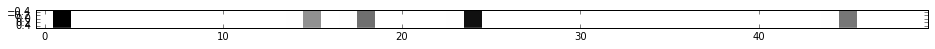

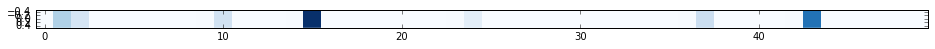

1941 9


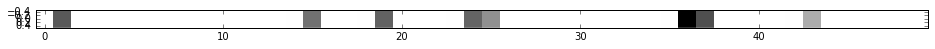

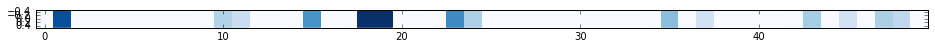

3422 4


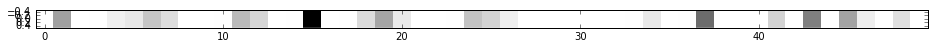

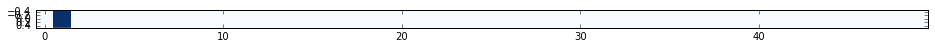

3607 23


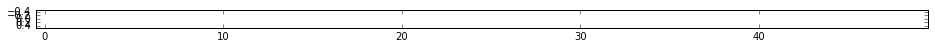

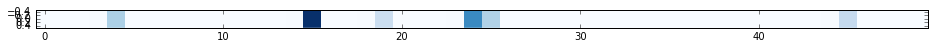

5205 3


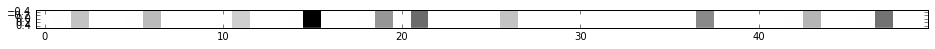

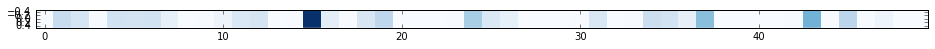

In [43]:
number = 5
objects = dict()
for repeat in range(number):
    ind = np.random.randint(0, len(test_target))
    while y_pred_1[ind] == test_target[ind]:
        ind = np.random.randint(0, len(y_pred_1))
         
    a = test_tf_idf.getrow(ind)[:, :50].todense()
    plt.figure(figsize=(16, 2))
    plt.imshow(a,interpolation='none',cmap='binary')
    
    real = 0
    while test_target[real] != y_pred_1[ind]:
        real = real + 1
    print (ind, real)    
    plt.figure(figsize=(16, 2))
    b = test_tf_idf.getrow(real)[:, :50].todense()
    plt.figure(figsize=(16, 2))
    plt.imshow(b,interpolation='none',cmap=plt.cm.Blues)
    plt.show()

Можем заметить, что даже на первых 50 признаках объекты в парах похожи. У них имеются признаки с одинаковой интенсивностью.

In [44]:
def plot_confusion_matrix(cm, title, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

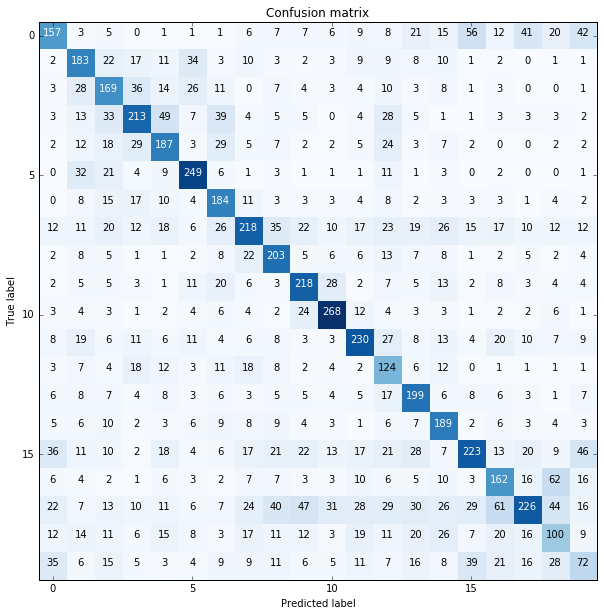

In [45]:
cnf_matrix = confusion_matrix(y_pred_1, test_target)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, 'Confusion matrix')

По матрице ошибок можно увидеть, какие классы наиболее часто были ошибочно классифицированы. Например, классфикатор 62 раза принимал 16 класс за 19.

Данная матрица так же удобна тем, что по ней можно посчитать практически все метрики.

# Итоговые выводы:

Для того, чтобы получить качественных классфикатор, необходимо правильно настроить его параметры.

Рассмотрим достоинства и недостатки метода ближайших соседей.

Плюсы KNN:
    + Прост в реализации
    + Можно перебирать метрики и количество соседей, тем самым улучшая качество
Минусы KNN:
    - Небольшое количество параметров для настройки
    - Чувствителен к выбросам
    - Занимает много места в памяти, потому что необходимо хранить всю выборку.

Повторю выводы про структуры данных:

Если размерность невелика (малое количество признаков), то следует использовать сложные структуры данных, так как они значительно ускоряют процесс поиска соседей, а, следовательно, и скорость предсказания. Но тем временем они требуют больше времени на построение.

Итак, при подборе структуры данных следует учитывать размерность пространства признаков.

В каждом конкретном случае нужно подбирать подходящие параметры, чтобы улучшить качество классификации.